In [1]:
# Literate.notebook("equirect1.jl"; execute=false)

Modules
==============================

In [2]:
using Tullio
using PyPlot
using BenchmarkTools
using ProgressMeter
using LinearAlgebra
using FFTW
FFTW.set_num_threads(Threads.nthreads())

using CMBLensing
import CirculantCov as CC # https://github.com/EthanAnderes/CirculantCov.jl

using Test

# LATER: remove LBblock dependence
using LBblocks: @sblock # https://github.com/EthanAnderes/LBblocks.jl

hide_plots = false

false

Set the grid geometry
============================

In [3]:
pj = @sblock let

    φspan = (5.3, CC.in_0_2π(5.3 + 2π/3))
    φ     = CC.fraccircle(φspan[1], φspan[2], 768)
    Δφ    = CC.counterclock_Δφ(φ[1], φ[2])
    φ∂    = vcat(φ, CC.in_0_2π(φ[end] + Δφ))

    # θ, θ∂ = CMBLensing.θ_grid(; θspan=(2.3,2.7), N= 1270, type=:equicosθ)
    # θ, θ∂ = CMBLensing.θ_grid(; θspan=(2.3,2.7), N= 512, type=:healpix)
    θ, θ∂ = CMBLensing.θ_grid(; θspan=(2.3,2.7), N= 2372, type=:equiθ)

    # TODO: when computing Ω use CC.counterclock_Δφ(φ[1], φ[2])
    # to handle the edge case that φ[1] < 2π & φ[2] > 0
    CMBLensing.ProjEquiRect(; θ, φ, θ∂, φ∂)
end;

Testing:

In [4]:
@test pj.Ny == length(pj.θ)
@test pj.Nx == length(pj.φ)

Test Passed

Testing: make a linear list `θ∂[1], θ[1], θ∂[2], θ[2], ..., θ∂[n], θ[n], θ∂[n+1]`
and test that it is strictly increasing.

In [5]:
∂θ∂ = vcat(vcat(pj.θ∂[1:end-1]', pj.θ')[:],  pj.θ∂[end])
@test all(diff(∂θ∂) .> 0)

Test Passed

Testing:

In [6]:
let θ∂ = [pi/2, 3pi/4, pi]
    Ω = 2π .* diff(.- cos.(θ∂))
    @test sum(Ω) ≈ 4pi/2
end

Test Passed

In [7]:
@show extrema(@. rad2deg(√pj.Ω)*60)

extrema(#= In[7]:1 =# @__dot__(rad2deg(√(pj.Ω)) * 60)) = (4.280634701275581, 5.63710272174319)


(4.280634701275581, 5.63710272174319)

Plot √Ωpix over ring θ's

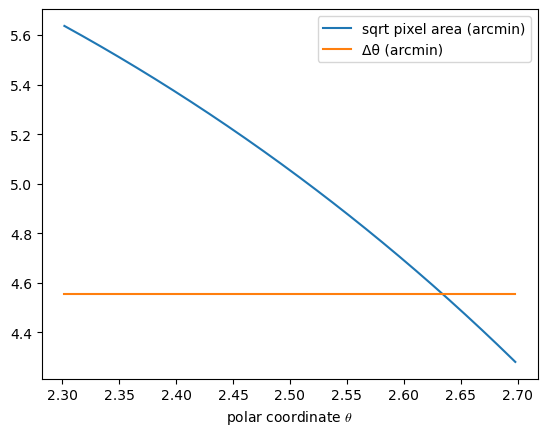

In [8]:
@sblock let pj, hide_plots
    hide_plots && return
    fig,ax = subplots(1)
    ax.plot(pj.θ, rad2deg.(.√pj.Ω)*60, label="sqrt pixel area (arcmin)")
    ax.plot(pj.θ, rad2deg.(diff(pj.θ∂))*60, label="Δθ (arcmin)")
    ax.set_xlabel(L"polar coordinate $\theta$")
    ax.legend()
    return nothing
end

Quick test
============================

In [9]:
ϕ = EquiRectMap(randn(Float64, pj.Ny, pj.Nx), pj)
P = EquiRectQUMap(randn(ComplexF64, pj.Ny, pj.Nx), pj);

In [10]:
ϕ′ = AzFourier(ϕ)
P′ = QUAzFourier(P);

In [11]:
@test AzFourier(ϕ′) isa EquiRectAzFourier
@test QUAzFourier(P′) isa EquiRectQUAzFourier

@test all(Map(AzFourier(ϕ′)).arr .≈ ϕ′[:])
@test all(QUMap(QUAzFourier(P′)).arr .≈ P′[:])

Test Passed

In [12]:
@inferred 2 * ϕ + ϕ′
@inferred 2 * P + P′;

Spectral densities
==============================

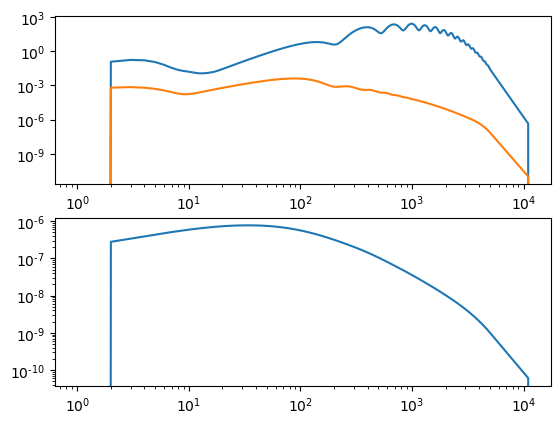

In [13]:
ℓ, CEEℓ, CBBℓ, CΦΦℓ = @sblock let ℓmax = 11000
	ℓ    = 0:ℓmax
	Cℓ   = camb(;r=0.01, ℓmax);
	CBBℓ = Cℓ.tensor.BB(ℓ)
	CEEℓ = Cℓ.unlensed_scalar.EE(ℓ)
	CΦΦℓ = Cℓ.unlensed_scalar.ϕϕ(ℓ)
	for cl in (CEEℓ, CBBℓ, CΦΦℓ)
		cl[.!isfinite.(cl)] .= 0
	end

	return ℓ, CEEℓ, CBBℓ, CΦΦℓ
end

@sblock let hide_plots, ℓ, CEEℓ, CBBℓ, CΦΦℓ
	hide_plots && return
	fig, ax = subplots(2)
	ax[1].plot(ℓ, @. ℓ^2*CEEℓ)
	ax[1].plot(ℓ, @. ℓ^2*CBBℓ)
	ax[2].plot(ℓ, @. ℓ^4*CΦΦℓ)
	ax[1].set_xscale("log")
	ax[2].set_xscale("log")
	ax[1].set_yscale("log")
	ax[2].set_yscale("log")
	return nothing
end

Block diagonal cov matrices
==============================

In [14]:
EB▫, Phi▫  = @sblock let ℓ, CEEℓ, CBBℓ, CΦΦℓ, θ=pj.θ, φ=pj.φ

    nθ, nφ = length(θ), length(φ)

    Γ_Phi  = CC.Γθ₁θ₂φ₁φ⃗_Iso(ℓ, CΦΦℓ; ngrid=50_000)
    ΓC_EB  = CC.ΓCθ₁θ₂φ₁φ⃗_CMBpol(ℓ, CEEℓ, CBBℓ; ngrid=50_000)

    ptmW    = FFTW.plan_fft(Vector{ComplexF64}(undef, nφ))

    T     = ComplexF64 # ComplexF32
    rT    = real(T)
    EB▫   = zeros(T,2nθ,2nθ,nφ÷2+1)
    Phi▫  = zeros(rT,nθ,nθ,nφ÷2+1)

    prgss = Progress(nθ, 1, "EB▫, Phi▫")
    for k = 1:nθ
        for j = 1:nθ
            Phiγⱼₖℓ⃗  = CC.γθ₁θ₂ℓ⃗(θ[j], θ[k], φ, Γ_Phi,  ptmW)
            EBγⱼₖℓ⃗, EBξⱼₖℓ⃗ = CC.γθ₁θ₂ℓ⃗_ξθ₁θ₂ℓ⃗(θ[j], θ[k], φ, ΓC_EB..., ptmW)
            for ℓ = 1:nφ÷2+1
                Jℓ = CC.Jperm(ℓ, nφ)
                Phi▫[j,k, ℓ] = real(Phiγⱼₖℓ⃗[ℓ])
                EB▫[j,   k   , ℓ]   = EBγⱼₖℓ⃗[ℓ]
                EB▫[j,   k+nθ, ℓ]   = EBξⱼₖℓ⃗[ℓ]
                EB▫[j+nθ,k   , ℓ]   = conj(EBξⱼₖℓ⃗[Jℓ])
                EB▫[j+nθ,k+nθ, ℓ]   = conj(EBγⱼₖℓ⃗[Jℓ])
            end
        end
        next!(prgss)
    end

    @show Base.summarysize(EB▫) / 1e9
    @show Base.summarysize(Phi▫)  / 1e9

    return EB▫, Phi▫
end;

EB▫, Phi▫100%|██████████████████████████████████████████| Time: 0:02:38


Base.summarysize(EB▫) / 1.0e9 = 2.217600048
Base.summarysize(Phi▫) / 1.0e9 = 0.277200048


TODO: add summary for BlockDiagEquiRect

In [15]:
EB▪   = BlockDiagEquiRect{QUAzFourier}(EB▫, pj)
Phi▪  = BlockDiagEquiRect{AzFourier}(Phi▫, pj);

Testing out indexing

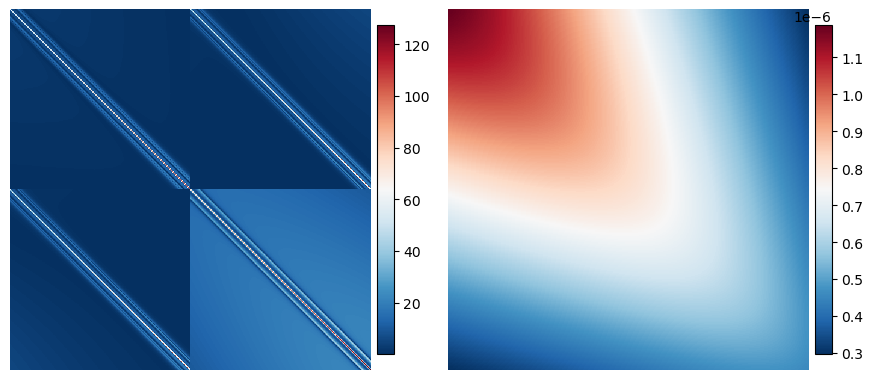

In [16]:
@sblock let EB▪, Phi▪, idx = 2, hide_plots
    hide_plots && return
    fig,ax = subplots(1,2,figsize=(9,5))
    EB▪[idx]   .|> abs |> imshow(-, fig, ax[1])
    Phi▪[idx]  .|> abs |> imshow(-, fig, ax[2])
    return nothing
end

Testing out indexing

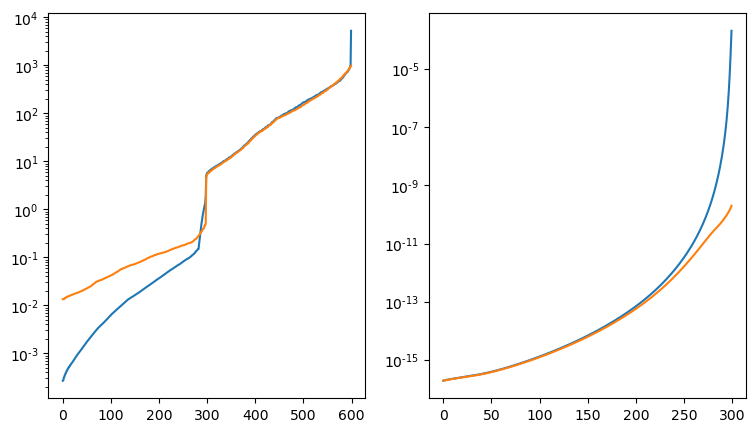

In [17]:
@sblock let EB▪, Phi▪, idx1 = 2, idx2 = 40, hide_plots
    hide_plots && return
    fig,ax = subplots(1,2,figsize=(9,5))
    ax[1].semilogy(eigen(Hermitian(EB▪[idx1])).values)
    ax[1].semilogy(eigen(Hermitian(EB▪[idx2])).values)
    ax[2].semilogy(eigen(Symmetric(Phi▪[idx1])).values)
    ax[2].semilogy(eigen(Symmetric(Phi▪[idx2])).values)
    return nothing
end

Test simulation of ϕmap, Qmap, Umap
=======================================

Why can't I get this to dispatch to proj_equirect.jl ??

In [18]:
ϕsim = map(Phi▪, EquiRectMap(randn(Float64,pj.Ny,pj.Nx),pj) ) do M, v
    cholesky(Symmetric(M)).L * v
end;

Why can't I get this to dispatch to proj_equirect.jl ??

In [19]:
Psim = map(EB▪, EquiRectQUMap(randn(ComplexF64,pj.Ny,pj.Nx),pj)) do M, v
    cholesky(Hermitian(M)).L * v
end;

plot maps of the simulated fields.
Currently turned off since the above are not working like I want

In [20]:
# @sblock let ϕsim, Psim, hide_plots
#     hide_plots && return
#     fig,ax = subplots(3,figsize=(9,9))
#     ϕsim[:]  |> imshow(-, fig, ax[1])
#     Psim[:] .|> real |> imshow(-, fig, ax[2]) # Qsim
#     Psim[:] .|> imag |> imshow(-, fig, ax[3]) # Usim
#     return nothing
# end

Simulation with pre-computed sqrt
=======================================

In [21]:
EB▪½  = map(EB▪) do M
    Matrix(sqrt(Hermitian(M)))
end |> x->BlockDiagEquiRect{QUAzFourier}(x,pj)

Phi▪½  = map(Phi▪) do M
    Matrix(sqrt(Hermitian(M)))
end |> x->BlockDiagEquiRect{AzFourier}(x,pj);

generate simulation

In [22]:
ϕsim = Phi▪½ * EquiRectMap(randn(Float64,pj.Ny,pj.Nx),pj)
Psim = EB▪½ * EquiRectQUMap(randn(ComplexF64,pj.Ny,pj.Nx),pj);

plot maps of the simulated fields

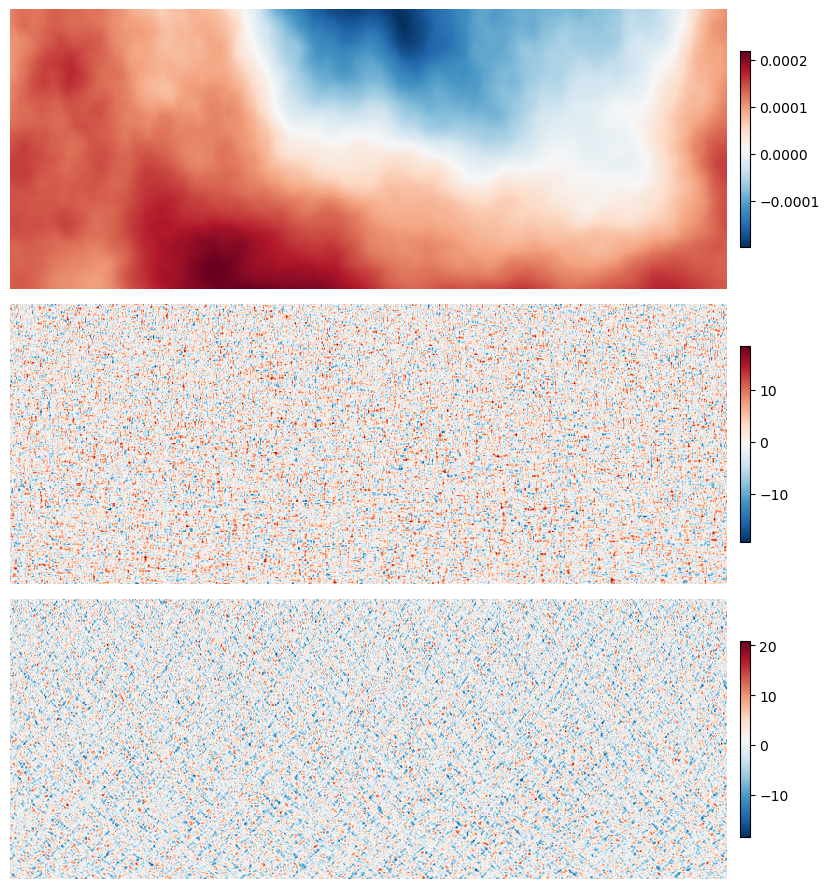

In [23]:
@sblock let ϕsim, Psim, hide_plots
    hide_plots && return
    fig,ax = subplots(3,figsize=(9,9))
    ϕsim[:]  |> imshow(-, fig, ax[1])
    Psim[:] .|> real |> imshow(-, fig, ax[2]) # Qsim
    Psim[:] .|> imag |> imshow(-, fig, ax[3]) # Usim
    return nothing
end

TODO:
=======================================
• Need to make sure the sign of U matches CMBLensing ... probably just need a negative spin 2 option in CirculantCov

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*